In [1]:
import os
import sys
import urllib, io
os.getcwd()
sys.path.append("..")
sys.path.append("../utils")
proj_dir = os.path.abspath('../..')

if os.path.join(proj_dir,'stimuli') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'stimuli'))

import numpy as np
import scipy.stats as stats
import pandas as pd
from scipy.spatial import distance
from random import random
from sklearn.cluster import SpectralBiclustering
import itertools
from scipy.optimize import linear_sum_assignment

import pymongo as pm
from collections import Counter
import json
import re
import ast

from PIL import Image, ImageOps, ImageDraw, ImageFont 

from io import BytesIO
import base64

import  matplotlib
from matplotlib import pylab, mlab, pyplot
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
from matplotlib import colors

import seaborn as sns
sns.set_context('talk')
sns.set_style('darkgrid')

from IPython.display import clear_output

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

import blockworld_helpers as utils
import drawing_utils as drawing
import importlib
import scoring
import rda

In [2]:
## directory & file hierarchy
proj_dir = os.path.abspath('../..')
datavol_dir = os.path.join(proj_dir,'data')
analysis_dir = os.path.abspath(os.path.join(os.getcwd(),'..'))
results_dir = os.path.join(analysis_dir,'results')
stim_dir = os.path.join(proj_dir,'stimuli')
plot_dir = os.path.join(results_dir,'plots')
csv_dir = os.path.join(results_dir,'csv')
json_dir = os.path.join(results_dir,'json')
exp_dir = os.path.abspath(os.path.join(proj_dir,'experiments'))
png_dir = os.path.abspath(os.path.join(datavol_dir,'png'))
jefan_dir = os.path.join(analysis_dir,'jefan')
will_dir = os.path.join(analysis_dir,'will')

## add helpers to python path
if os.path.join(proj_dir,'stimuli') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'stimuli'))
    
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
    
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)   
    
if not os.path.exists(csv_dir):
    os.makedirs(csv_dir)       

In [3]:
stim_dir

'/Users/will/block_construction/stimuli'

In [4]:
iteration_name = 'Exp2Pilot3'
num_trials = 24 #for sanity checks

In [5]:
# Data already compiled into dataframes in CogSci 2020 Dataframe Generator

# trial_end data
trial_path = os.path.join(csv_dir,'block_silhouette_{}_good.csv'.format(iteration_name))
df = pd.read_csv(trial_path)

# # initial_block data
initial_path = os.path.join(csv_dir,'block_silhouette_initial_{}_good.csv'.format(iteration_name))
dfi = pd.read_csv(initial_path)

# # settled_block data
settled_path = os.path.join(csv_dir,'block_silhouette_settled_{}_good.csv'.format(iteration_name))
dfs = pd.read_csv(settled_path)

# # Sanity Check- same participants in each dataset.
df_participants = df.gameID.unique()
dfs_participants = dfs.gameID.unique()
assert Counter(df_participants) == Counter(dfs_participants)

n_before_outliers = len(df_participants)
print(str(n_before_outliers) + ' participants total')

dfi['usableDiscreteWorld'] = dfi['discreteWorld'].apply(lambda a: 1+(-1)*np.array(ast.literal_eval(a)))
dfi['flatDiscreteWorld'] = dfi['discreteWorld'].apply(lambda a: (1+(-1)*np.array(ast.literal_eval(a))).flatten())

49 participants total


## Actions

Placement of block: <w,h,x,y>

Only certain placements are possible at any one time: i.e. those just above the current tower (including in holes).

Consider set of actions as possible block placements *inside the silhouette* plus an error action- placing a block anywhere outside the silhouette.


In [7]:
blocks = np.array([[1,2],[2,1],[2,2],[2,4],[4,2]]) # block dimensions
locations = np.arange(0,8) # locations to place blocks- inside 8x8 grid only

### Maps of silhouette

In [13]:
target_dir = os.path.join(stim_dir,'hand_selected_e2_subset')

## load in list of structures
file_list = os.listdir(target_dir)
file_list = [x for x in file_list if not (x.startswith('.'))]

print('Loaded {} structures.'.format(len(file_list)))

target_blocks_dict = {}

## loop through list of good sequences, and build list of versions, each containing a trial list 
Meta = [] ## initialize list of all trial lists
for i,f in enumerate(file_list):
    target = pd.read_json(os.path.join(target_dir,f)) ## stim list
    targetName = f.split('.')[0]
    targetBlocks = list(target['blocks'].values)
    target_blocks_dict[targetName] = targetBlocks

Loaded 8 structures.


In [14]:
stimWidth = 8
worldWidth = 18
worldHeight = 13

target_maps = {}

for i, (target_name, block_list) in enumerate(target_blocks_dict.items()):
    #block_list = target_blocks_dict['hand_selected_009']
    target_map = np.zeros([worldWidth,worldHeight])

    for block in block_list:
        # add block to map
        width = block['width']
        height = block['height']
        blockLeft = int((worldWidth-stimWidth)/2) + block['x']
        blockBottom = block['y']
        blockTop = blockBottom + height
        blockRight = blockLeft + width

        #console.log('width', width);
        #console.log('height', height);
        #console.log('blockLeft', blockLeft);
        #console.log('blockBottom', blockBottom);
        for y in range(blockBottom,blockTop):
            for x in range(blockLeft, blockRight):
                target_map[x][y] = 1
    
    target_maps[target_name] = target_map
    

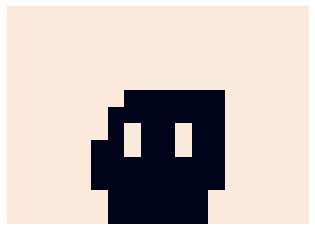

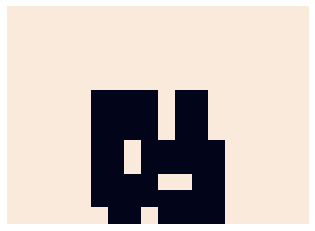

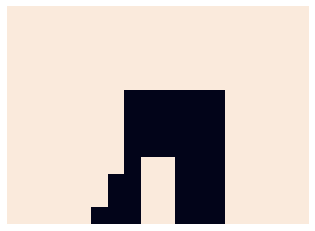

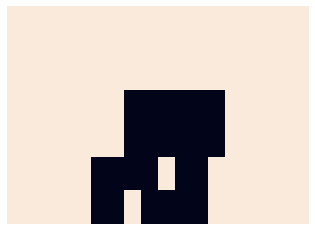

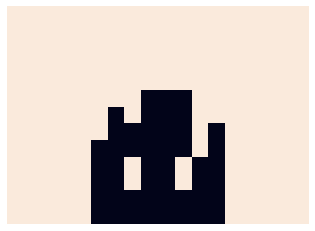

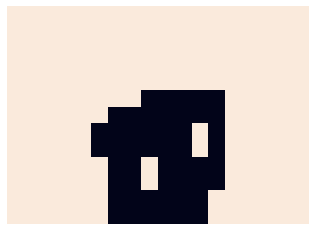

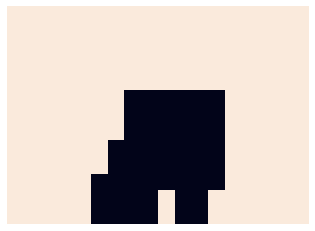

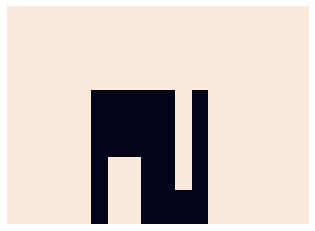

In [15]:
for i, (target_name, target_map) in enumerate(target_maps.items()):
    silhouette = 1*np.logical_not(target_map)
    silhouette = np.rot90(silhouette)
    fig, ax = plt.subplots()
    ax.axis('off')
    ax.imshow(silhouette)

### Enumerate actions within silhouette

In [ ]:
silhouette = 1*np.logical_not(target_maps['hand_selected_012'])
silhouette = np.rot90(silhouette)
fig, ax = plt.subplots()
ax.axis('off')
ax.imshow(silhouette)

In [ ]:
tm = target_maps['hand_selected_012']

In [ ]:
tm[5:12,0:8] # Slice only the silhouette

for a current world state:
find set of viable actions

iterate through layers (keep track of floors?)
for each block find viable locations
or 
for each location find viable blocks

some of these paths will lead to dead ends

## Actual distributions of human behavior

Look at the sequences of actions people actually take
And see how close they are
Do they end up closer (by rep 4)?

Similarity:
Closer if: 
Same blocks in same place
Same blocks in same placed placed at similar time

In [ ]:
dfi['usableDiscreteWorld'] = dfi['discreteWorld'].apply(lambda a: 1+(-1)*np.array(ast.literal_eval(a)))
dfi['flatDiscreteWorld'] = dfi['discreteWorld'].apply(lambda a: (1+(-1)*np.array(ast.literal_eval(a))).flatten())

In [ ]:
# We have sequences of world states, of length n where n is the number of blocks placed
# Each layer is a block placement
dfi['flatDiscreteWorld'][0]

Vector representing where blocks have been placed
Want to look at sequences of these
If people complete the silhouette, these vectors will be the same
Differing numbers of blocks mean the list of these vectors will be different lengths

## Discrete World State

In [ ]:
# get world state EVERY SECOND
# i.e. the flatDiscreteWorld for the highest time preceding i 
# for every participant, for every structure

targets = np.sort(df['targetName'].unique())
ppts = np.sort(df['gameID'].unique())

n_targets = df['targetName'].nunique()
n_ppts = df['gameID'].nunique()

m = np.zeros((n_targets,n_ppts,61,13*18)) #number of seconds, number of squares in grid

for t, t_name in enumerate(targets):
    for p, p_id in enumerate(ppts):
        subset = dfi[(dfi.targetName==t_name) & (dfi.gameID==p_id) & (dfi.phase=='pre')]
        prev_world = np.zeros(13*18)
        i = 0
        for index, row in subset.iterrows():
            while ((i*1000 < row['relativePlacementTime']) & ((i*1000)<60000)):
                m[t,p,i,:] = prev_world
                i += 1
            prev_world = row['flatDiscreteWorld']
        while (i < 60):
            m[t,p,i,:] = prev_world
            i += 1


In [ ]:
# get world state EVERY 10 SECONDS
# i.e. the flatDiscreteWorld for the highest time preceding i 
# PRE PHASE, for every participant, for every structure

targets = np.sort(df['targetName'].unique())
ppts = np.sort(df['gameID'].unique())

n_targets = df['targetName'].nunique()
n_ppts = df['gameID'].nunique()

m = np.zeros((n_targets,n_ppts,6,13*18)) #number of seconds, number of squares in grid

for t, t_name in enumerate(targets):
    for p, p_id in enumerate(ppts):
        subset = dfi[(dfi.targetName==t_name) & (dfi.gameID==p_id) & (dfi.phase=='pre')]
        prev_world = np.zeros(13*18)
        i = 0
        for index, row in subset.iterrows():
            while ((i*10000 < row['relativePlacementTime']) & ((i*10000)<60000)):
                m[t,p,i,:] = prev_world
                i += 1
            prev_world = row['flatDiscreteWorld']
        while (i < 6):
            m[t,p,i,:] = prev_world
            i += 1


In [ ]:
# get world state EVERY 10 SECONDS
# i.e. the flatDiscreteWorld for the highest time preceding i 
# POST PHASE, for every participant, for every structure

targets = np.sort(df['targetName'].unique())
ppts = np.sort(df['gameID'].unique())

n_targets = df['targetName'].nunique()
n_ppts = df['gameID'].nunique()

m2 = np.zeros((n_targets,n_ppts,6,13*18)) #number of seconds, number of squares in grid

for t, t_name in enumerate(targets):
    for p, p_id in enumerate(ppts):
        subset = dfi[(dfi.targetName==t_name) & (dfi.gameID==p_id) & (dfi.phase=='post')]
        prev_world = np.zeros(13*18)
        i = 0
        for index, row in subset.iterrows():
            while ((i*10000 < row['relativePlacementTime']) & ((i*10000)<60000)):
                m2[t,p,i,:] = prev_world
                i += 1
            prev_world = row['flatDiscreteWorld']
        while (i < 6):
            m2[t,p,i,:] = prev_world
            i += 1


In [ ]:
# (targets, participants, seconds, squares)
# for one target, get all participants
mat = m[3,:,50,:]

## Explore matrix creation (compare ppt world state for a given structure over time)

In [ ]:
# Create rdm for a given structure and time step (all ppts, one phase)

mat = m[3,:,1,:]
n_rows = mat.shape[0]

rdm = np.zeros((n_rows,n_rows))

for i in range (0, n_rows): # row dim
    for j in range (0, n_rows): # row dim
        rdm[i,j] = distance.euclidean(mat[i,:],mat[j,:])
        

img = plt.matshow(rdm)
img.set_cmap('hot')
plt.axis('off')
plt.savefig("test.png", bbox_inches='tight')
plt.colorbar()

In [ ]:
# Use biclustering to arrange rows and columns. 
# This seems ok, except you have to specify the amount of clusters and the initial random state seems to have quite a large effect

mat = m[1,:,2,:]
n_rows = mat.shape[0]

rdm = np.zeros((n_rows,n_rows))

for i in range (0, n_rows): # row dim
    for j in range (0, n_rows): # row dim
        rdm[i,j] = distance.euclidean(mat[i,:],mat[j,:])

clustering = SpectralBiclustering(n_clusters=5, random_state=0).fit(rdm) # https://scikit-learn.org/stable/auto_examples/bicluster/plot_spectral_biclustering.html
order = clustering.row_labels_

sorted_rdm = rdm[np.argsort(clustering.row_labels_)]
sorted_rdm = sorted_rdm[:, np.argsort(clustering.column_labels_)]

img1 = plt.matshow(rdm)
plt.axis('off')
plt.colorbar()
img2 = plt.matshow(sorted_rdm)
plt.axis('off')
img1.set_cmap('hot')
img2.set_cmap('hot')
plt.colorbar()

In [ ]:
importlib.reload(scoring)

In [ ]:
# Create and display RDMs for one structure (all ppts, one phase)

mat = m[3,:,:,:]

n_rows = mat.shape[0]
time_steps = mat.shape[1]

rdm = np.zeros((n_rows,n_rows, time_steps))

for step in range(0,time_steps):
    for i in range (0, n_rows): # row dim
        for j in range (0, n_rows): # row dim
            rdm[i,j,step] = scoring.get_jaccard(mat[i,step,:],mat[j,step,:])
        
for step in range(0,time_steps):
    img = plt.matshow(rdm[:,:,step])
    img.set_cmap('hot')
    plt.axis('off')
    plt.savefig("test.png", bbox_inches='tight')
    plt.colorbar()

## Sequences of world states by action

In [ ]:
# Spread flatDiscreteWorld over columns

dfic = dfi[dfi.condition=='repeated']
dfic = dfic[['targetName','gameID','blockNum','repetition','flatDiscreteWorld']]

# Create index names
# for i in range(0,len(dfi['flatDiscreteWorld'][0])):
#     inds.append('w_' + str(i).zfill(3))

# Create columns from values in flatDiscreteWorld
world_cols = dfic.apply(lambda x: pd.Series(x['flatDiscreteWorld']), axis=1)
dfic = pd.concat([dfic, world_cols], axis=1)

In [ ]:
# Make empty values for non-existent blockNums 

targets = np.sort(df['targetName'].unique())
ppts = np.sort(df['gameID'].unique())
reps = np.sort(df['repetition'].unique())
max_actions = dfic['blockNum'].max()

# create multi-index
block_placement_index = (
    pd.MultiIndex
    .from_product(
        iterables=[targets, ppts, reps, range(1,max_actions + 1)],
        names=['targetName', 'gameID','repetition','blockNum']
    )
)

# set indexes, then replace with full product index, filling blank values with NaNs 
world_states = dfic.set_index(['targetName', 'gameID','repetition','blockNum']).\
    reindex(index=block_placement_index, fill_value=np.nan).reset_index()

In [ ]:
# Get scores for each pair of repetitions

importlib.reload(scoring)

rep_pairs = list(combinations(reps,2))

def get_scores(x):
    tmp_df = pd.DataFrame(rep_pairs,
                          columns=['rep_a','rep_b'])
    #tmp_df = tmp_df.assign(score=lambda r: x[x.repetition==r.rep_a]['flatDiscreteWorld'])
    tmp_df['score'] = tmp_df.apply(lambda r: scoring.get_jaccard(\
                            x[x.repetition==r.rep_a].iloc[:,5:].values,\
                            x[x.repetition==r.rep_b].iloc[:,5:].values),\
                                                    axis=1)
    return tmp_df

scores_df = world_states.groupby(['targetName','gameID','blockNum']).apply(lambda x: get_scores(x))\
                               .reset_index()

In [ ]:
rep_pairs = list(combinations(reps,2))
rep_pairs

In [ ]:
# Add convenient names for pairs of repeititons
scores_df['reps'] = scores_df.apply(lambda row: str(int(row.rep_a)) + ' to ' + str(int(row.rep_b)), axis = 1) 

In [ ]:
scores_sample = scores_df[scores_df.reps.isin(['0 to 1','1 to 2','2 to 3'])]

g = sns.FacetGrid(scores_sample, col="targetName", col_wrap=2, height=6, hue="reps")
g.map(sns.lineplot, "blockNum", "score");
g.map(sns.scatterplot, "blockNum", "score");
plt.legend(bbox_to_anchor=(1.0,1))

In [ ]:
# Label pairs of repetitions by amount of overlap

def same_diff_from_jaccard(j):
    if np.isnan(j):
        return 'no values'
    elif j==1:
        return 'same'
    elif j==0:
        return 'no overlap'
    else:
        return 'overlap'
    
v_s = np.vectorize(same_diff_from_jaccard)
    
scores_df['samediff'] = v_s(scores_df.score)

In [ ]:
scores_sample = scores_df[(scores_df.targetName==targets[0]) & (scores_df.reps.isin(['0 to 1','1 to 2','2 to 3']))]

# g = sns.FacetGrid(scores_sample, col="reps", col_wrap=2, height=6, hue="samediff")
# g.map(sns.barplot, "blockNum", );
# plt.legend(bbox_to_anchor=(1.0,1))

In [ ]:
scores_df.groupby(['targetName','blockNum','reps'])['samediff'].value_counts()

In [ ]:
# calculate all distances

# each small multiple is a target structure
# rows and columns are repetitions
# each value is a within participant, within structure, within action index, across repetition distance
# each layer is an action
targets = np.sort(df['targetName'].unique())
ppts = np.sort(df['gameID'].unique())
reps = np.sort(df['repetition'].unique())

n_targets = df['targetName'].nunique()
n_ppts = df['gameID'].nunique()
n_reps = df['repetition'].nunique()
n_grid_squares = 13*18

max_actions = df['numBlocks'].max()

dfic = dfi[['targetName','gameID','blockNum','condition','repetition','flatDiscreteWorld']]
dfic = dfic[dfic.condition=='repeated']

n_rows = n_reps
n_cols = n_reps

all_dists = np.zeros((n_targets, n_ppts, max_actions, n_rows, n_cols))

df_dists = pd.DataFrame(columns=['target', 'participant', 'block_num','rep_a','rep_b','dist'])

for t in range(0, n_targets):
    for p in range(0, n_ppts):
        for a in range(0, max_actions):
            for rep_a in range (0, n_rows): # row dim
                for rep_b in range (0, n_cols): # col dim
                    world_a = all_worlds[t,p,a,rep_a,:]
                    world_b = all_worlds[t,p,a,rep_b,:]
                    all_dists[t,p,a,rep_a,rep_b] = scoring.get_jaccard(world_a,world_b)
#                     df_dists = df_dists.append({'target': t,
#                                     'participant': p, 
#                                     'block_num': a,
#                                     'rep_a': rep_a,
#                                     'rep_b': rep_b,
#                                     'dist':scoring.get_jaccard(world_a,world_b)}, ignore_index=True)

In [ ]:
v_jaccard = np.vectorize(scoring.get_jaccard)

In [ ]:
img = plt.matshow(all_dists[1,3,8,:,:])
img.set_cmap('hot')
plt.axis('off')
plt.colorbar()

In [ ]:
for action in range(0, max_actions):
    action_dists = all_dists[1,:,action,:,:]
    img.set_cmap('hot')
    norm = plt.Normalize(0, 1)
    img = plt.matshow(np.nanmean(action_dists, axis=0), norm=norm)
    plt.axis('off')
    plt.colorbar()

In [ ]:
plt.set_cmap('hot')
cmap = plt.cm.get_cmap()
cmap.set_bad(color='green')
norm = plt.Normalize(0, 1)

for action in range(0, max_actions):
    img = plt.matshow(all_dists[0,5,action,:,:], cmap = cmap, norm=norm)
    plt.axis('off')
    plt.colorbar()

In [ ]:
#all_dists = (n_targets, n_ppts, max_actions, n_rows, n_cols)

In [ ]:
mean_dists_ppts = np.mean(all_dists[:,:,:,:,:], axis = 1)
mean_dists_ppts.shape

In [ ]:
df_dists['reps'] = df_dists.apply(lambda row: str(int(row.rep_a)) + ' to ' + str(int(row.rep_b)), axis = 1) 

In [ ]:
#fig = plt.figure(figsize=(10,6))
g = sns.FacetGrid(df_dists, row="target", hue="rep_a")
g.map(sns.scatterplot, "block_num", "dist")

In [ ]:
fig = plt.figure()
fig.set_size_inches(12, 16)
sns.set(style="ticks", rc={"lines.linewidth": 1})
g = sns.FacetGrid(df_dists, col="target", hue="reps", col_wrap=2, height=8)
g.map(sns.scatterplot, "block_num", "dist", s=15)
g.map(sns.lineplot, "block_num", "dist")


#g.map(sns.lineplot, "block_num", "dist")

In [ ]:
df_dists.reps.unique()

In [ ]:
fig = plt.figure()
fig.set_size_inches(12, 16)
sns.set(style="ticks", rc={"lines.linewidth": 1})
g = sns.FacetGrid(df_dists[(df_dists.target==0) & (df_dists.participant.isin(range(0,5)))], col="reps", hue="participant", col_wrap=4, height=6)
g.map(sns.scatterplot, "block_num", "dist", s=15)
g.map(sns.pointplot, "block_num", "dist")


In [ ]:
target = 0

fig = plt.figure(figsize=(10, 20))

for t in range(0, n_targets): 
    plt.subplot(4,2,t+1)
    plt.plot(mean_dists_ppts[t,:,0,1], label="1 to 2", color=line_cmap[0])
    #plt.plot(mean_dists_ppts[t,:,0,2], label="1 to 3", color=line_cmap[1])
    #plt.plot(mean_dists_ppts[t,:,0,3], label="1 to 4", color=line_cmap[2])
    plt.plot(mean_dists_ppts[t,:,1,2], label="2 to 3", color=line_cmap[3])
    #plt.plot(mean_dists_ppts[t,:,1,3], label="2 to 4", color=line_cmap[4])
    plt.plot(mean_dists_ppts[t,:,2,3], label="3 to 4", color=line_cmap[5])
plt.legend()
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

In [ ]:
target = 0

fig = plt.figure(figsize=(10, 20))

for t in range(0, n_targets): 
    plt.subplot(4,2,t+1)
    plt.plot(mean_dists_ppts[t,:,0,1], label="1 to 2", color=line_cmap[0])
    plt.scatter(x = all_dists[:,t,1,0,1], label="1 to 2", color=line_cmap[0])
    #plt.plot(mean_dists_ppts[t,:,0,2], label="1 to 3", color=line_cmap[1])
    #plt.plot(mean_dists_ppts[t,:,0,3], label="1 to 4", color=line_cmap[2])
    plt.plot(mean_dists_ppts[t,:,1,2], label="2 to 3", color=line_cmap[3])
    #plt.plot(mean_dists_ppts[t,:,1,3], label="2 to 4", color=line_cmap[4])
    plt.plot(mean_dists_ppts[t,:,2,3], label="3 to 4", color=line_cmap[5])
plt.legend()
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

At each time point
Relative proportion of full/partial/zero overlap
Each point has a distribution of Jaccard numbers


Over time, integration- area under curves

In [ ]:
target = 0

fig = plt.figure(figsize=(10, 20))

for t in range(0, n_targets): 
    plt.subplot(4,2,t+1)
    plt.plot(all_dists[t,1,:,0,1], label="1 to 2", color=line_cmap[0])
    plt.plot(all_dists[t,1,:,0,2], label="1 to 3", color=line_cmap[1])
    plt.plot(all_dists[t,1,:,0,3], label="1 to 4", color=line_cmap[2])
    plt.plot(all_dists[t,1,:,1,2], label="2 to 3", color=line_cmap[3])
    plt.plot(all_dists[t,1,:,1,3], label="2 to 4", color=line_cmap[4])
    plt.plot(all_dists[t,1,:,2,3], label="3 to 4", color=line_cmap[5])
plt.legend()
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    


## Test Jaccard

In [ ]:
arr1, arr2 = np.zeros((13,18)), np.zeros((13,18))

arr1[0:2,6:10] = 1
plt.matshow(arr1)
print('arr1: ', np.count_nonzero(arr1))

arr2[0:2,7:11] = 1
print('arr2: ', np.count_nonzero(arr1))
plt.matshow(arr2)

print('Jaccard: ', scoring.get_jaccard(arr1,arr2))

In [ ]:
importlib.reload(rda)

all_dists, all_values = rda.rda_from_df(dfi[(dfi.gameID == ppts[0])], 
    row_col='repetition', 
    value_col='flatDiscreteWorld',
    small_multiple_col='targetName', 
    layer_col='blockNum')

In [ ]:
all_dists.shape

# Action-centric analysis of build sequences

## Create Dataframe and Matrices

In [9]:
# Make action dataframe
dfa = dfi[['gameID','trialNum','targetName','repetition','blockNum','condition','phase_extended','y_index','x_index','width_discrete','height_discrete']]
dfa = dfa.rename(columns = {'y_index':'y',
                            'x_index':'x',
                            'width_discrete':'w',
                            'height_discrete':'h'})

targets = np.sort(df['targetName'].unique())
ppts = np.sort(df['gameID'].unique())
extended_phases = ['pre', 'repetition 1', 'repetition 2', 'post']

## Experiment with one structure

In [10]:
# Choose which sequences to compare
truncating = True;

pptA = ppts[15]
targetA = targets[5]
phaseA = extended_phases[0]

pptB = ppts[15]
targetB = targets[5]
phaseB = extended_phases[3]

### Calculate distance matrix and visualize

In [13]:
# Calculate distance matrix

# select two sets of actions e.g. compare one ppts attempts at one structure pre to post
s1 = dfa[(dfa.gameID == pptA) & (dfa.targetName == targetA) & (dfa.phase_extended == phaseA)]
s2 = dfa[(dfa.gameID == pptB) & (dfa.targetName == targetB) & (dfa.phase_extended == phaseB)]

# truncate to length of smaller set of actions
n_actions = min(len(s1),len(s2))

if truncating:
    s1 = s1.iloc[0:n_actions]
    s2 = s2.iloc[0:n_actions]

# apply distance metric between each 4-tuple in the sequence (but append s1 to s2)
s1_s2 = s1.append(s2)

dist_mat = s1_s2.apply(lambda r: 
            s1_s2.apply(lambda r2: 
                distance.euclidean(r[['x','y','w','h']],r2[['x','y','w','h']]),
                axis=1),
            axis=1)

A: left, top, B: right, bottom


(0.0, 900.0, 0.0, 900.0)

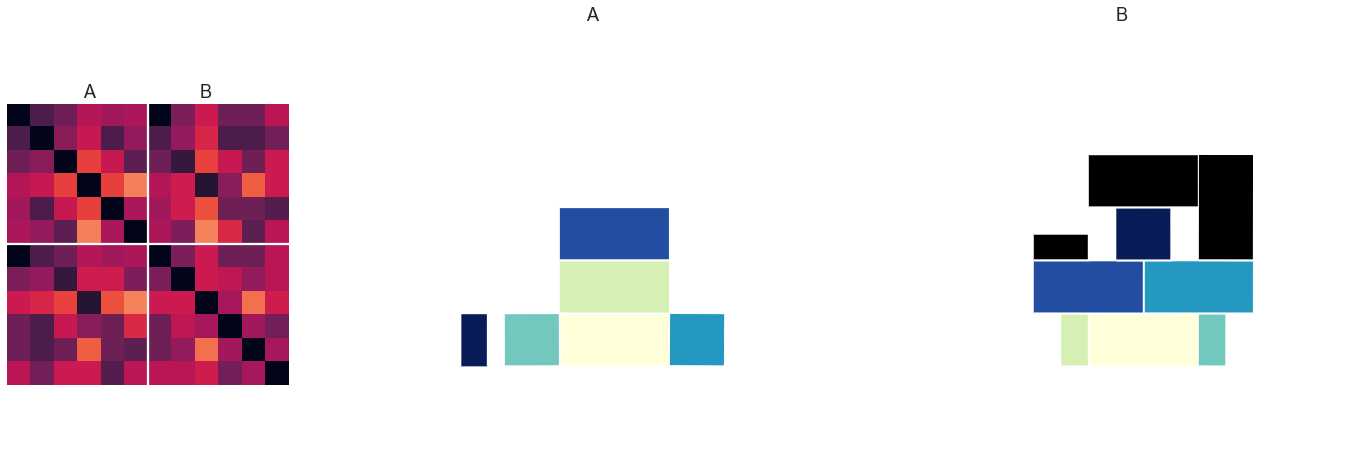

In [12]:
# Plot matrix and structures
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(24,8),
                       gridspec_kw={
                           'width_ratios': [1, 1.6, 1.6]})

ax[0].axis('off')
ax[0].imshow(dist_mat,vmin=0,vmax=10)
ax[0].axvline(x=(len(s1))-0.5, ymin=0, ymax=2*(len(s1))+1,color='white')
ax[0].axhline(y=(len(s1))-0.5, xmin=0, xmax=2*(len(s1))+1,color='white')
ax[0].set_title('A                     B')
print('A: left, top, B: right, bottom')

# fig2, ax2 = plt.subplots(figsize=(3,3))
drawing.draw_reconstruction_subplot(df=df[df.phase_extended == phaseA],gameID=pptA,targetName=targetA, ax=ax[1], n_colors = n_actions)
#draw_from_actions_subplot(dfa[(dfa.phase_extended == phaseA) & (dfa.gameID==pptA) & (dfa.targetName==targetA)], ax[1])
ax[1].set_title('A')
ax[1].axis('off')

# fig3, ax2 = plt.subplots(figsize=(3,3))
drawing.draw_reconstruction_subplot(df=df[df.phase_extended == phaseB],gameID=pptB,targetName=targetB, ax=ax[2], n_colors = n_actions)
# draw_from_actions_subplot(dfa[(dfa.phase_extended == phaseB) & (dfa.gameID==pptB) & (dfa.targetName==targetB)], ax[2])
ax[2].set_title('B')
ax[2].axis('off')

## 1. Directly compare internal structures of each sequence
Different measures are going to do different things here.
Flattening upper triangles and taking cosine distance

Text(0.5, 1.0, 'BB')

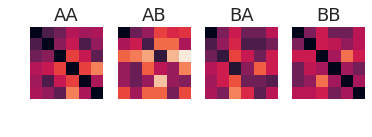

In [170]:
AA = dist_mat.values[0:len(s1),0:len(s1)]
AB = dist_mat.values[len(s1):,0:len(s1)]
BA = dist_mat.values[0:len(s1),len(s1):]
BB = dist_mat.values[len(s1):,len(s1):]

fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(6,2))

ax[0].axis('off')
ax[0].imshow(AA, vmin=0,vmax=10) 
ax[0].set_title('AA')
ax[1].axis('off', vmin=0,vmax=10)
ax[1].imshow(AB)
ax[1].set_title('AB')
ax[2].axis('off')
ax[2].imshow(BA, vmin=0,vmax=10)
ax[2].set_title('BA')
ax[3].axis('off')
ax[3].imshow(BB, vmin=0,vmax=10)
ax[3].set_title('BB')

Cosine distance between upper triangles

In [83]:
assert (truncating == True) | (len(s1)==len(s2))

AA_triu = AA[np.triu_indices(n_actions, k=1)]
BB_triu = BB[np.triu_indices(n_actions, k=1)]

In [ ]:
distance.cosine(AA_triu, BB_triu)

### Decay function to find matches and near matches

In [ ]:
def exp_decay(x):
    return np.e**(-0.5 * (x/1)**2)

In [ ]:
AB_filtered = np.vectorize(exp_decay)(AB)
fig = plt.figure()
plt.imshow(AB_filtered)
AB_filtered

## 2. Detect block-diagonal structure
Not sure how to go about this
Clustering?

Wait until we are using chunkier structures

## 3. Looking at between-sequence distances. 

Find measure of similarity that takes into account the fact that people might make the same placement but at different times

Diagonal tells us if same action performed at same time.
Any off-diagonals should be taken into account but downweighted in some way

What does it mean to have a high score < 1 (less than max) here? 'Very similar action' not particularly meaningful here

### Explore Linear Sum Assignment (still working with one example from above)

This finds a mapping between two sequences that minimizes the total distances between each element.
It is being used here to find a 1-1 correspondence between block placements in two build sequences

In [15]:
# check displacements are equal in AB and BA case

AA = dist_mat.values[0:len(s1),0:len(s1)]
AB = dist_mat.values[len(s1):,0:len(s1)]
BA = dist_mat.values[0:len(s1),len(s1):]
BB = dist_mat.values[len(s1):,len(s1):]
 
sum_displacement_AB = sum(np.abs(np.arange(AB.shape[0]) - linear_sum_assignment(AB)[1]))
sum_displacement_BA = sum(np.abs(np.arange(BA.shape[0]) - linear_sum_assignment(BA)[1]))

print('Total displacement AB: ', sum_displacement_AB)
print('Total displacement BA: ', sum_displacement_BA)

Total displacement AB:  6
Total displacement BA:  6


Turns out the are not always equal! Linear sum assignments can have multiple optimal, with different arrangements

Text(0.5, 1.0, 'AB_sorted')

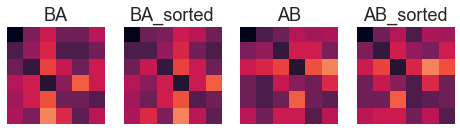

In [16]:
# Visualise the sort returned by linear_sum_assignment

AB_sorted = AB[:,linear_sum_assignment(AB)[1]]
BA_sorted = BA[:,linear_sum_assignment(BA)[1]]

fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(8,2))

ax[0].axis('off')
ax[0].imshow(BA, vmin=0,vmax=10)
ax[0].set_title('BA')
ax[1].axis('off')
ax[1].imshow(BA_sorted, vmin=0,vmax=10) 
ax[1].set_title('BA_sorted')
ax[2].axis('off')
ax[2].imshow(AB, vmin=0,vmax=10)
ax[2].set_title('AB')
ax[3].axis('off')
ax[3].imshow(AB_sorted, vmin=0,vmax=10)
ax[3].set_title('AB_sorted')

In [173]:
# Scaled displacement

AA = dist_mat.values[0:len(s1),0:len(s1)]
AB = dist_mat.values[len(s1):,0:len(s1)]
BA = dist_mat.values[0:len(s1),len(s1):]
BB = dist_mat.values[len(s1):,len(s1):]


sum_displacement_AB = np.mean((np.abs(np.arange(AB.shape[0]) - linear_sum_assignment(AB)[1])/(len(AB))))
sum_displacement_BA = np.mean((np.abs(np.arange(BA.shape[0]) - linear_sum_assignment(BA)[1])/(len(BA))))

print('Total displacement AB: ', sum_displacement_AB)
print('Total displacement BA: ', sum_displacement_BA)

Total displacement AB:  0.16666666666666666
Total displacement BA:  0.16666666666666666


## Experimentation

In [131]:
# for all participants, for all structures that are built 4 times

truncating = True;

dfa_repeated = dfa[dfa.condition=='repeated']

displacements = np.zeros([len(ppts),len(targets),4,4])

displacements = np.full_like(displacements, np.nan, dtype=np.double)

for i_p, ppt in enumerate(ppts):
    for i_t, target in enumerate(targets):
        
        dfar = dfa_repeated[(dfa_repeated.gameID==ppt) & (dfa_repeated.targetName==target)]

        # check if any row exists for this ppt, structure pair
        if (dfar[(dfar.gameID==ppt) & (dfar.targetName==target)]['x'].any()):

            for i_pa, phaseA in enumerate(extended_phases):
                for i_pb, phaseB in enumerate(extended_phases):

                    if phaseA != phaseB:

                        # Calculate distance matrix

                        # select two sets of actions e.g. compare one ppts attempts at one structure pre to post
                        s1 = dfar[(dfar.phase_extended == phaseA)]
                        s2 = dfar[(dfar.phase_extended == phaseB)]

                        # truncate to length of smaller set of actions
                        n_actions = min(len(s1),len(s2))

                        if truncating:
                            s1 = s1.iloc[0:n_actions]
                            s2 = s2.iloc[0:n_actions]

                        BA = s1.apply(lambda r: 
                                    s2.apply(lambda r2: 
                                        distance.euclidean(r[['x','y','w','h']], r2[['x','y','w','h']]),
                                        axis=1),
                                    axis=1)


                        #sum_displacement_AB = np.mean((np.abs(np.arange(AB.shape[0]) - linear_sum_assignment(AB)[1])/(len(AB))))
                        sum_displacement_BA = np.mean((np.abs(np.arange(BA.shape[0]) - linear_sum_assignment(BA)[1])/(BA.shape[0])), dtype='float128')

                        displacements[i_p, i_t, i_pa, i_pb] = sum_displacement_BA



In [107]:
# Find any <row, structure> pairs that have different A->B from B->A values
# linear_sum_assignment finds a solution that optimizes Euclidean distance. There may be several of these.
# The pairs below indicate that different pairs were found

displacements2[np.isnan(displacements2)] = -1


same == True
for i_p, ppt in enumerate(ppts):
    for i_t, target in enumerate(targets):
        arr = np.reshape(displacements2[i_p,i_t,:,:],(4,4))
        same = same & (arr.transpose() == arr).all()
        if(not (arr.transpose() == arr).all()):
            print(i_p, i_t)
        
same

1 5
2 2
3 1
3 5
4 2
4 4
6 4
8 0
8 6
9 4
11 1
15 2
15 5
17 2
18 1
27 7
29 3
29 7
33 5
36 0
41 1
43 6
45 3
46 3
46 7


False

In [175]:
# Inspect phase displacement matrices for one participant and structure
displacements[3,5,:,:]

array([[       nan, 0.0625    , 0.21875   , 0.15625   ],
       [0.0625    ,        nan, 0.21875   , 0.21875   ],
       [0.21875   , 0.25      ,        nan, 0.20833333],
       [0.15625   , 0.21875   , 0.19444444,        nan]])

In [109]:
# Inspect mean displacement matrices for all structures
np.nanmean(displacements, axis=0, keepdims=True)

/home/wmccarth/anaconda3/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


array([[[[       nan, 0.1428432 , 0.1735974 , 0.15040862],
         [0.14245073,        nan, 0.11279779, 0.11484562],
         [0.1735974 , 0.11279779,        nan, 0.12857138],
         [0.14850929, 0.11484562, 0.12857138,        nan]],

        [[       nan, 0.15972018, 0.13354656, 0.16433942],
         [0.16120828,        nan, 0.12364692, 0.12654583],
         [0.13619207, 0.12364692,        nan, 0.11231501],
         [0.1655152 , 0.12654583, 0.11231501,        nan]],

        [[       nan, 0.1622118 , 0.19444586, 0.16008926],
         [0.16642807,        nan, 0.11849684, 0.12686831],
         [0.19444586, 0.11849684,        nan, 0.14625484],
         [0.16008926, 0.12758259, 0.14513877,        nan]],

        [[       nan, 0.14889422, 0.16642566, 0.13580276],
         [0.14556088,        nan, 0.12335932, 0.13929453],
         [0.16642566, 0.12335932,        nan, 0.11582686],
         [0.13913609, 0.13929453, 0.11479806,        nan]],

        [[       nan, 0.15431583, 0.1526573 , 0.

In [119]:
# Inspect mean displacement matrices for all structures, all participants
phase_differences = np.nanmean(np.nanmean(displacements, axis=0, keepdims=True), axis=1)[0]
phase_differences

/home/wmccarth/anaconda3/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  


array([[       nan, 0.16739544, 0.16631171, 0.16114947],
       [0.16788973,        nan, 0.13174545, 0.14464237],
       [0.16666437, 0.13214065,        nan, 0.1286312 ],
       [0.16147569, 0.14480428, 0.1284331 ,        nan]])

In [111]:
phase_differences_sem = stats.sem(np.nanmean(displacements, axis=0, keepdims=True), axis=1)
phase_differences_sem

/home/wmccarth/anaconda3/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


array([[[       nan, 0.00941754, 0.01213839, 0.01098429],
        [0.00956102,        nan, 0.00830661, 0.01062038],
        [0.01245347, 0.0083109 ,        nan, 0.00581203],
        [0.01089825, 0.01012581, 0.00576162,        nan]]])

In [121]:
phase_differences_se = np.nanstd(np.nanmean(displacements, axis=0), axis=0)/(np.sqrt(8))
phase_differences_se

/home/wmccarth/anaconda3/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.
/home/wmccarth/anaconda3/envs/py35/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:1545: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


array([[       nan, 0.0088093 , 0.01135442, 0.01027486],
       [0.00894352,        nan, 0.00777013, 0.00993446],
       [0.01164916, 0.00777414,        nan, 0.00543666],
       [0.01019438, 0.00947182, 0.0053895 ,        nan]])

Text(0.5, 1.0, 'Comparing average displacements between consecutive phases')

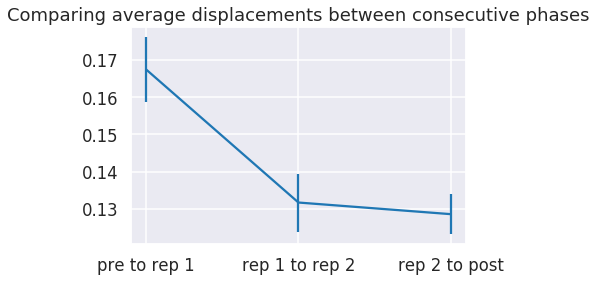

In [128]:
plt.errorbar(x = range(1,4), 
             y = [phase_differences[0,1],phase_differences[1,2],phase_differences[2,3]], 
             yerr=[phase_differences_se[0,1],phase_differences_se[1,2],phase_differences_se[2,3]])
plt.xticks([1,2,3],['pre to rep 1','rep 1 to rep 2','rep 2 to post'])
plt.title('Comparing average displacements between consecutive phases')

Text(0.5, 1.0, 'Comparing average displacements between each phase and posttest')

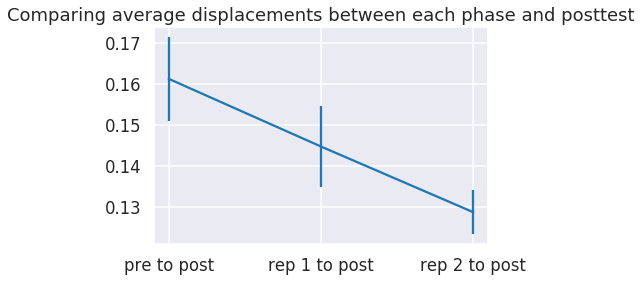

In [127]:
plt.errorbar(x = range(1,4), 
             y = [phase_differences[0,3],phase_differences[1,3],phase_differences[2,3]], 
             yerr=[phase_differences_se[0,3],phase_differences_se[1,3],phase_differences_se[2,3]])
plt.xticks([1,2,3],['pre to post','rep 1 to post','rep 2 to post'])
plt.title('Comparing average displacements between each phase and posttest')

In [132]:
# for all participants, for all structures that are built 4 times

truncating = True;

dfa_repeated = dfa[dfa.condition=='repeated']

raw_displacements = np.zeros([len(ppts),len(targets),4,4])

raw_displacements = np.full_like(displacements, np.nan, dtype=np.double)

for i_p, ppt in enumerate(ppts):
    for i_t, target in enumerate(targets):
        
        dfar = dfa_repeated[(dfa_repeated.gameID==ppt) & (dfa_repeated.targetName==target)]

        if (dfar[(dfar.gameID==ppt) & (dfar.targetName==target)]['x'].any()):

            for i_pa, phaseA in enumerate(extended_phases):
                for i_pb, phaseB in enumerate(extended_phases):

                    if phaseA != phaseB:

                        # Calculate distance matrix

                        # select two sets of actions e.g. compare one ppts attempts at one structure pre to post
                        s1 = dfar[(dfar.phase_extended == phaseA)]
                        s2 = dfar[(dfar.phase_extended == phaseB)]

                        # truncate to length of smaller set of actions
                        n_actions = min(len(s1),len(s2))

                        if truncating:
                            s1 = s1.iloc[0:n_actions]
                            s2 = s2.iloc[0:n_actions]

                        BA = s1.apply(lambda r: 
                                    s2.apply(lambda r2: 
                                        distance.euclidean(r[['x','y','w','h']], r2[['x','y','w','h']]),
                                        axis=1),
                                    axis=1)


                        #sum_displacement_AB = np.mean((np.abs(np.arange(AB.shape[0]) - linear_sum_assignment(AB)[1])/(len(AB))))
                        sum_displacement_BA = sum(np.abs(np.arange(BA.shape[0]) - linear_sum_assignment(BA)[1]))

                        raw_displacements[i_p, i_t, i_pa, i_pb] = sum_displacement_BA



In [136]:
# Inspect mean displacement matrices for all structures, all participants
raw_phase_differences = np.nanmean(np.nanmean(raw_displacements, axis=0, keepdims=True), axis=1)[0]
raw_phase_differences

raw_phase_differences_se = np.nanstd(np.nanmean(raw_displacements, axis=0), axis=0)/(np.sqrt(8))
raw_phase_differences_se

/home/wmccarth/anaconda3/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  
/home/wmccarth/anaconda3/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """
/home/wmccarth/anaconda3/envs/py35/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:1545: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


array([[       nan, 1.56752843, 1.35993019, 1.42892289],
       [1.56613968,        nan, 1.39294587, 1.63713138],
       [1.37201746, 1.43501893,        nan, 1.43330156],
       [1.41902948, 1.61976596, 1.43779797,        nan]])

Text(0.5, 1.0, 'Comparing average displacements between consecutive phases')

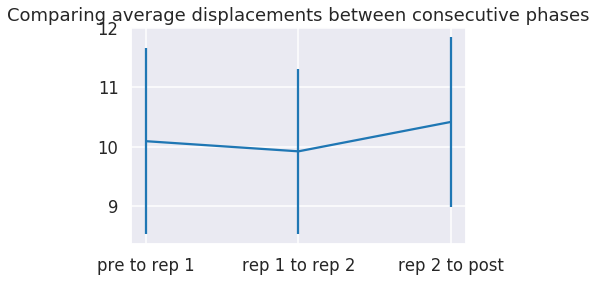

In [137]:
plt.errorbar(x = range(1,4), 
             y = [raw_phase_differences[0,1],raw_phase_differences[1,2],raw_phase_differences[2,3]], 
             yerr=[raw_phase_differences_se[0,1],raw_phase_differences_se[1,2],raw_phase_differences_se[2,3]])
plt.xticks([1,2,3],['pre to rep 1','rep 1 to rep 2','rep 2 to post'])
plt.title('Comparing average displacements between consecutive phases')

Text(0.5, 1.0, 'Comparing average displacements between each phase and posttest')

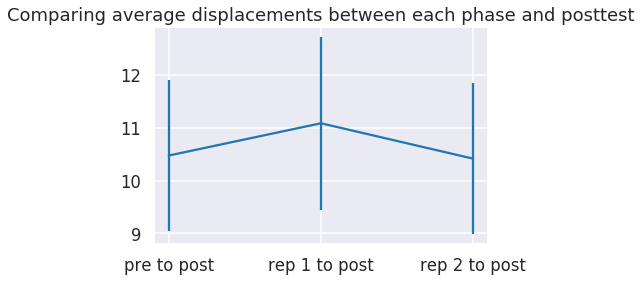

In [138]:
plt.errorbar(x = range(1,4), 
             y = [raw_phase_differences[0,3],raw_phase_differences[1,3],raw_phase_differences[2,3]], 
             yerr=[raw_phase_differences_se[0,3],raw_phase_differences_se[1,3],raw_phase_differences_se[2,3]])
plt.xticks([1,2,3],['pre to post','rep 1 to post','rep 2 to post'])
plt.title('Comparing average displacements between each phase and posttest')

In [139]:
# for all participants, for all structures that are built 4 times
# Meaned but not scaled

truncating = True;

dfa_repeated = dfa[dfa.condition=='repeated']

unscaled_displacements = np.zeros([len(ppts),len(targets),4,4])

unscaled_displacements = np.full_like(displacements, np.nan, dtype=np.double)

for i_p, ppt in enumerate(ppts):
    for i_t, target in enumerate(targets):
        
        dfar = dfa_repeated[(dfa_repeated.gameID==ppt) & (dfa_repeated.targetName==target)]

        # check if any row exists for this ppt, structure pair
        if (dfar[(dfar.gameID==ppt) & (dfar.targetName==target)]['x'].any()):

            for i_pa, phaseA in enumerate(extended_phases):
                for i_pb, phaseB in enumerate(extended_phases):

                    if phaseA != phaseB:

                        # Calculate distance matrix

                        # select two sets of actions e.g. compare one ppts attempts at one structure pre to post
                        s1 = dfar[(dfar.phase_extended == phaseA)]
                        s2 = dfar[(dfar.phase_extended == phaseB)]

                        # truncate to length of smaller set of actions
                        n_actions = min(len(s1),len(s2))

                        if truncating:
                            s1 = s1.iloc[0:n_actions]
                            s2 = s2.iloc[0:n_actions]

                        BA = s1.apply(lambda r: 
                                    s2.apply(lambda r2: 
                                        distance.euclidean(r[['x','y','w','h']], r2[['x','y','w','h']]),
                                        axis=1),
                                    axis=1)


                        #sum_displacement_AB = np.mean((np.abs(np.arange(AB.shape[0]) - linear_sum_assignment(AB)[1])/(len(AB))))
                        sum_displacement_BA = np.mean((np.abs(np.arange(BA.shape[0]) - linear_sum_assignment(BA)[1])), dtype='float128')

                        unscaled_displacements[i_p, i_t, i_pa, i_pb] = sum_displacement_BA



In [140]:
# Inspect mean displacement matrices for all structures, all participants
unscaled_phase_differences = np.nanmean(np.nanmean(unscaled_displacements, axis=0, keepdims=True), axis=1)[0]
unscaled_phase_differences

unscaled_phase_differences_se = np.nanstd(np.nanmean(unscaled_displacements, axis=0), axis=0)/(np.sqrt(8))
unscaled_phase_differences_se

/home/wmccarth/anaconda3/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  
/home/wmccarth/anaconda3/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """
/home/wmccarth/anaconda3/envs/py35/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:1545: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


array([[       nan, 0.13304166, 0.11984213, 0.12220482],
       [0.13294667,        nan, 0.09419609, 0.12865777],
       [0.12191908, 0.09706876,        nan, 0.09934254],
       [0.12125887, 0.1262268 , 0.09972913,        nan]])

Text(0.5, 1.0, 'Comparing average displacements between consecutive phases')

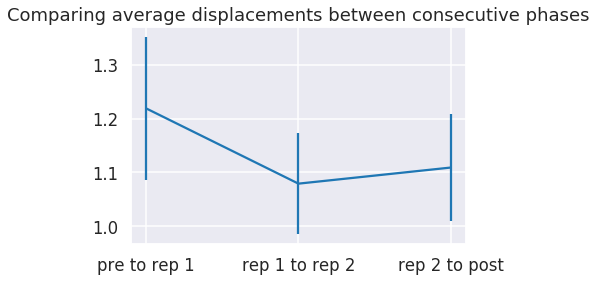

In [141]:
plt.errorbar(x = range(1,4), 
             y = [unscaled_phase_differences[0,1],unscaled_phase_differences[1,2],unscaled_phase_differences[2,3]], 
             yerr=[unscaled_phase_differences_se[0,1],unscaled_phase_differences_se[1,2],unscaled_phase_differences_se[2,3]])
plt.xticks([1,2,3],['pre to rep 1','rep 1 to rep 2','rep 2 to post'])
plt.title('Comparing average displacements between consecutive phases')

Text(0.5, 1.0, 'Comparing average displacements between each phase and posttest')

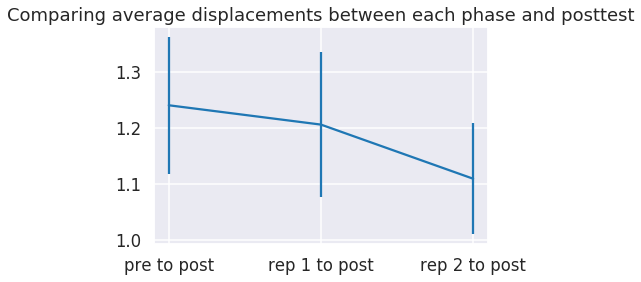

In [142]:
plt.errorbar(x = range(1,4), 
             y = [unscaled_phase_differences[0,3],unscaled_phase_differences[1,3],unscaled_phase_differences[2,3]], 
             yerr=[unscaled_phase_differences_se[0,3],unscaled_phase_differences_se[1,3],unscaled_phase_differences_se[2,3]])
plt.xticks([1,2,3],['pre to post','rep 1 to post','rep 2 to post'])

plt.title('Comparing average displacements between each phase and posttest')

## Functions for applying any spatial distance metric, and any sequence/string distance metric

In [208]:
# Create a dataframe with columns: ppt, structure, from_phase, to_phase, distance

# 1. Define functions and useful arrays

# reps = np.sort(df['phase_extended'].unique())
# phase_pairs = list(itertools.combinations(reps,2))
targets = np.sort(df['targetName'].unique())
ppts = np.sort(df['gameID'].unique())
extended_phases = ['pre', 'repetition 1', 'repetition 2', 'post']
all_phase_pairs = list(itertools.combinations(extended_phases,2))

                                            
def get_mean_displacement(distance_matrix):
    '''
    Takes a distance matrix, finds optimal mapping of rows, and returns the mean displacement of each action to achieve mapping

    '''
    displacements = (np.abs(np.arange(distance_matrix.shape[0]) - linear_sum_assignment(distance_matrix)[1])/distance_matrix.shape[0])
    mean_displacement = np.mean(displacements)
    return mean_displacement

def kendall_tau_distance(distance_matrix):
    '''
    Percent of pairs of indices that occur in a different order
    This metric ranges between -1 and 1, and is higher for more similar orders/strings
    '''
    kt = stats.kendalltau(np.arange(distance_matrix.shape[0]), linear_sum_assignment(distance_matrix)[1])[0]
    return kt

def get_distance_matrix(A,B,distance_measure=distance.euclidean, truncating = True):
    '''
    Returns distance matrix truncated to shortest sequence
    '''

    # truncate to length of smaller set of actions
    n_actions = min(len(A),len(B))

    if truncating:
        A = A.iloc[0:n_actions]
        B = B.iloc[0:n_actions]

    B_to_A = A.apply(lambda r: 
                B.apply(lambda r2: 
                    distance_measure(r[['x','y','w','h']], r2[['x','y','w','h']]),
                    axis=1),
                axis=1)

    return B_to_A

def get_phase_displacements(group, displacement_measure = get_mean_displacement, distance_measure=distance.euclidean):
    '''
    Group is a dataframe (usually groupby of targetName and gameID)
    displacement_measure calculates some temporal distance, or difference between sorts of action sequences
    distance_measure is the distance between action vectors [x,y,w,h]
    '''
    if group.phase_extended.nunique() == 2:
        phase_pairs = [('pre','post')]
    else:
        phase_pairs = all_phase_pairs

    phase_df = pd.DataFrame(phase_pairs,
                            columns=['phase_a','phase_b'])
        
    phase_df['temporal_distance'] = phase_df.apply(lambda r: displacement_measure(
                                            get_distance_matrix(\
                                                group[group.phase_extended==r.phase_a],\
                                                group[group.phase_extended==r.phase_b],\
                                                distance_measure)),                           
                                            axis=1)
    return phase_df

def get_aggregate_distances(group, distance_measure=distance.euclidean):
    '''
    Group is a dataframe (usually groupby of targetName and gameID)
    distance_measure is the distance between action vectors [x,y,w,h]
    '''
    if group.phase_extended.nunique() == 2:
        phase_pairs = [('pre','post')]
    else:
        phase_pairs = all_phase_pairs

    phase_df = pd.DataFrame(phase_pairs,
                            columns=['phase_a','phase_b'])
        
    phase_df['actual_euclidean_distance'] = phase_df.apply(lambda r: np.mean(\
                                            np.diag(\
                                                get_distance_matrix(\
                                                    group[group.phase_extended==r.phase_a],\
                                                    group[group.phase_extended==r.phase_b],\
                                                    distance_measure))),
                                         axis=1)
    return phase_df


def get_optimal_aggregate_distances(group, distance_measure=distance.euclidean):
    '''
    Group is a dataframe (usually groupby of targetName and gameID)
    distance_measure is the distance between action vectors [x,y,w,h]
    '''
    if group.phase_extended.nunique() == 2:
        phase_pairs = [('pre','post')]
    else:
        phase_pairs = all_phase_pairs

    phase_df = pd.DataFrame(phase_pairs,
                            columns=['phase_a','phase_b'])
        
    phase_df['optimal_euclidean_distance'] = phase_df.apply(lambda r:\
                                      np.mean(\
                                          np.diag(\
                                                optimal_sort(\
                                                #distance matrix sorted by optimal order    
                                                    get_distance_matrix(\
                                                        group[group.phase_extended==r.phase_a],\
                                                        group[group.phase_extended==r.phase_b],\
                                                        distance_measure).values))),

                                     axis=1)
    
    return phase_df

def optimal_sort(distance_matrix):
    optimal_assignment = linear_sum_assignment(distance_matrix)[1]
    sorted_matrix = distance_matrix[:, optimal_assignment]
    return sorted_matrix



In [203]:
list(itertools.combinations(['pre','post'],2))

[('pre', 'post')]

### Action sequence similarity (what and where). 

In [212]:
# 2. Subset data
dfa = dfi[['gameID','trialNum','targetName','repetition','blockNum','condition','phase_extended','y_index','x_index','width_discrete','height_discrete']]
dfa = dfa.rename(columns = {'y_index':'y',
                            'x_index':'x',
                            'width_discrete':'w',
                            'height_discrete':'h'})


In [213]:
# Group by ppt and targetName, apply spatial-distance measure and aggregate by taking mean of the diagonal
df_optimal_euclidean_distances = dfa.groupby(['targetName','gameID'])\
        .apply(lambda x: get_optimal_aggregate_distances(x))\
        .reset_index()


# 4. Add phase-to-phase column
df_optimal_euclidean_distances['phase_pair'] = df_optimal_euclidean_distances.apply(\
            lambda row: row.phase_a + ' to ' + row.phase_b, axis = 1)

In [214]:
df_optimal_euclidean_distances

,targetName,gameID,level_2,phase_a,phase_b,optimal_euclidean_distance,phase_pair
0,hand_selected_004,0145-8cab6010-6b88-4e57-b04d-b9e9b4b7c959,0,pre,post,3.100925,pre to post
1,hand_selected_004,0443-fd078367-c19d-495d-84d5-3519a281435d,0,pre,repetition 1,0.844291,pre to repetition 1
2,hand_selected_004,0443-fd078367-c19d-495d-84d5-3519a281435d,1,pre,repetition 2,0.844291,pre to repetition 2
3,hand_selected_004,0443-fd078367-c19d-495d-84d5-3519a281435d,2,pre,post,0.936887,pre to post
4,hand_selected_004,0443-fd078367-c19d-495d-84d5-3519a281435d,3,repetition 1,repetition 2,0.000000,repetition 1 to repetition 2
...,...,...,...,...,...,...,...
1367,hand_selected_016,9995-aa7dd1d6-ff3f-41e8-ade6-da416e7366c3,1,pre,repetition 2,0.000000,pre to repetition 2
1368,hand_selected_016,9995-aa7dd1d6-ff3f-41e8-ade6-da416e7366c3,2,pre,post,1.746204,pre to post
1369,hand_selected_016,9995-aa7dd1d6-ff3f-41e8-ade6-da416e7366c3,3,repetition 1,repetition 2,2.793158,repetition 1 to repetition 2
1370,hand_selected_016,9995-aa7dd1d6-ff3f-41e8-ade6-da416e7366c3,4,repetition 1,post,1.320706,repetition 1 to post


/Users/will/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


<Figure size 864x1152 with 0 Axes>

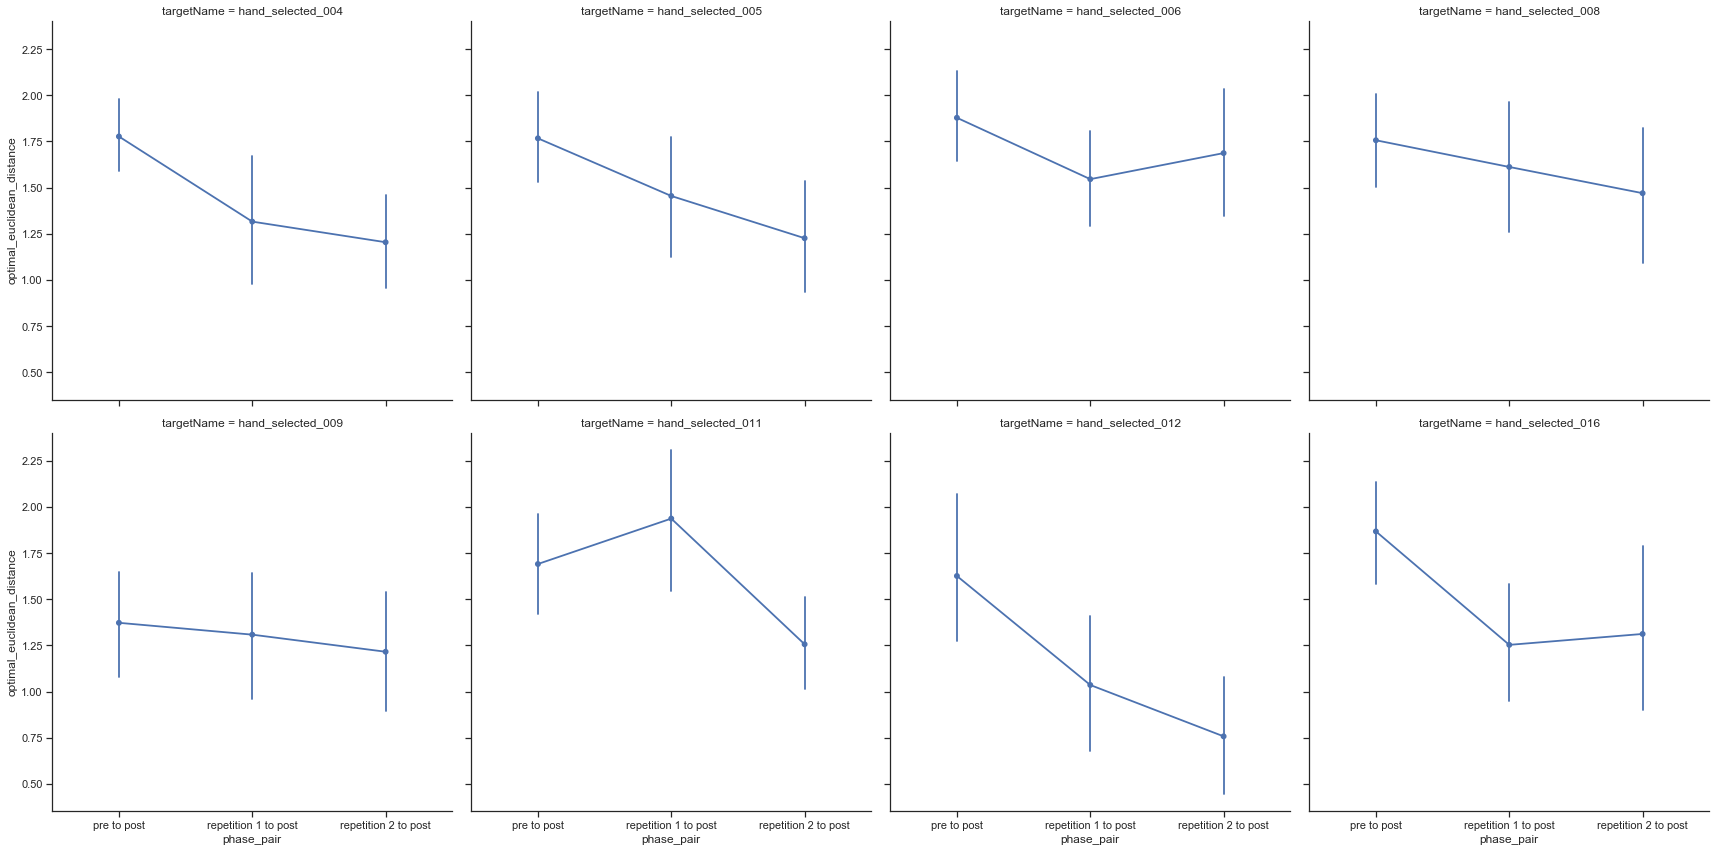

In [215]:
df_tmp = df_optimal_euclidean_distances[df_optimal_euclidean_distances.phase_pair.isin(['pre to post',
                                                                    'repetition 1 to post',
                                                                    'repetition 2 to post'])]

fig = plt.figure()
fig.set_size_inches(12, 16)
sns.set(style="ticks", rc={"lines.linewidth": 1})
g = sns.FacetGrid(df_tmp, col="targetName", col_wrap=4, height=6)
g.map(sns.pointplot, "phase_pair", "optimal_euclidean_distance")

In [216]:
df_euclidean_distances = dfa.groupby(['targetName','gameID'])\
        .apply(lambda x: get_aggregate_distances(x))\
        .reset_index()


# 4. Add phase-to-phase column
df_euclidean_distances['phase_pair'] = df_euclidean_distances.apply(\
            lambda row: row.phase_a + ' to ' + row.phase_b, axis = 1)

In [217]:
df_euclidean_distances

,targetName,gameID,level_2,phase_a,phase_b,actual_euclidean_distance,phase_pair
0,hand_selected_004,0145-8cab6010-6b88-4e57-b04d-b9e9b4b7c959,0,pre,post,5.088994,pre to post
1,hand_selected_004,0443-fd078367-c19d-495d-84d5-3519a281435d,0,pre,repetition 1,2.711420,pre to repetition 1
2,hand_selected_004,0443-fd078367-c19d-495d-84d5-3519a281435d,1,pre,repetition 2,2.490231,pre to repetition 2
3,hand_selected_004,0443-fd078367-c19d-495d-84d5-3519a281435d,2,pre,post,2.340887,pre to post
4,hand_selected_004,0443-fd078367-c19d-495d-84d5-3519a281435d,3,repetition 1,repetition 2,1.272144,repetition 1 to repetition 2
...,...,...,...,...,...,...,...
1367,hand_selected_016,9995-aa7dd1d6-ff3f-41e8-ade6-da416e7366c3,1,pre,repetition 2,0.816497,pre to repetition 2
1368,hand_selected_016,9995-aa7dd1d6-ff3f-41e8-ade6-da416e7366c3,2,pre,post,4.929865,pre to post
1369,hand_selected_016,9995-aa7dd1d6-ff3f-41e8-ade6-da416e7366c3,3,repetition 1,repetition 2,4.572609,repetition 1 to repetition 2
1370,hand_selected_016,9995-aa7dd1d6-ff3f-41e8-ade6-da416e7366c3,4,repetition 1,post,5.956067,repetition 1 to post


<Figure size 864x1152 with 0 Axes>

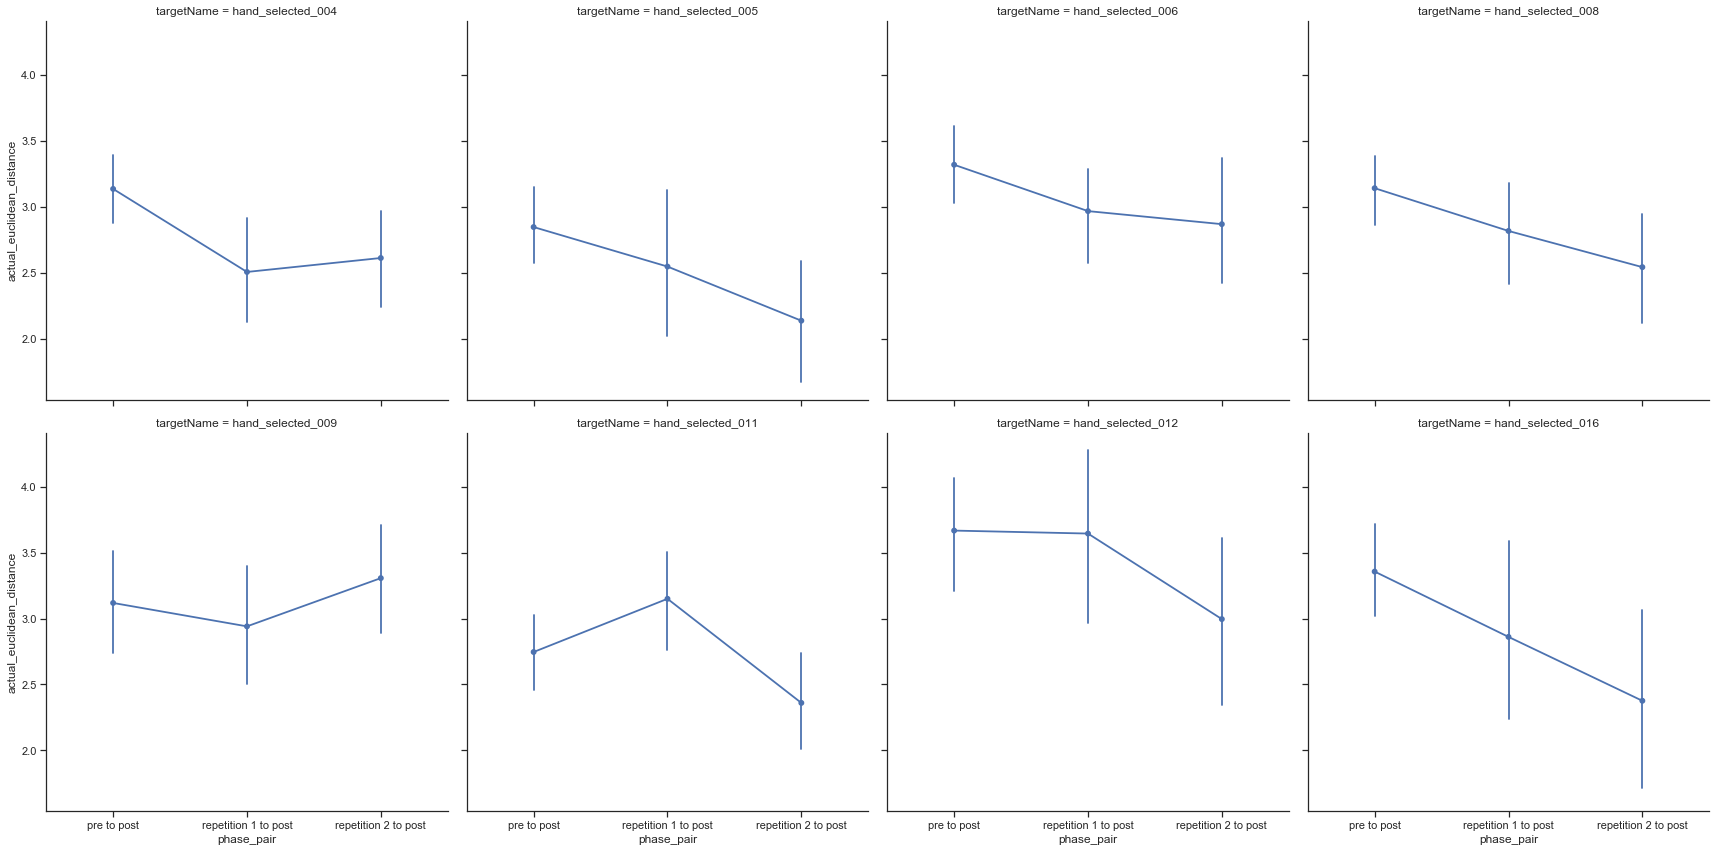

In [218]:
df_tmp = df_euclidean_distances[df_euclidean_distances.phase_pair.isin(['pre to post',
                                                                    'repetition 1 to post',
                                                                    'repetition 2 to post'])]


fig = plt.figure()
fig.set_size_inches(12, 16)
sns.set(style="ticks", rc={"lines.linewidth": 1})
g = sns.FacetGrid(df_tmp, col="targetName", col_wrap=4, height=6)
g.map(sns.pointplot, "phase_pair", "actual_euclidean_distance")

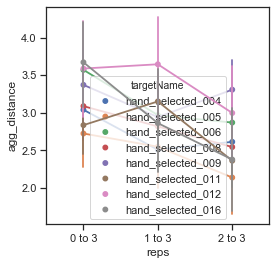

In [68]:
df_tmp = df_euclidean_distances[df_euclidean_distances.reps.isin(['0 to 3','1 to 3','2 to 3'])]

fig = plt.figure()
fig.set_size_inches(4, 4)
sns.set(style="ticks", rc={"lines.linewidth": 1})
sns.pointplot(data=df_tmp, x="reps", y="agg_distance", hue='targetName')

### Action sequence similarity (when). 

In [219]:
# 2. Subset data
dfa = dfi[['gameID','trialNum','targetName','repetition','blockNum','condition','phase_extended','y_index','x_index','width_discrete','height_discrete']]
dfa = dfa.rename(columns = {'y_index':'y',
                            'x_index':'x',
                            'width_discrete':'w',
                            'height_discrete':'h'})

In [220]:
# 3. Group by ppt and targetName, apply spatial-distance and time-displacement measures
df_temporal = dfa.groupby(['targetName','gameID']).apply(lambda x: get_phase_displacements(x, displacement_measure = kendall_tau_distance))\
                               .reset_index()

# 4. Add phase-to-phase column
df_temporal['phase_pair'] = df_temporal.apply(\
            lambda row: row.phase_a + ' to ' + row.phase_b, axis = 1)

<Figure size 864x1152 with 0 Axes>

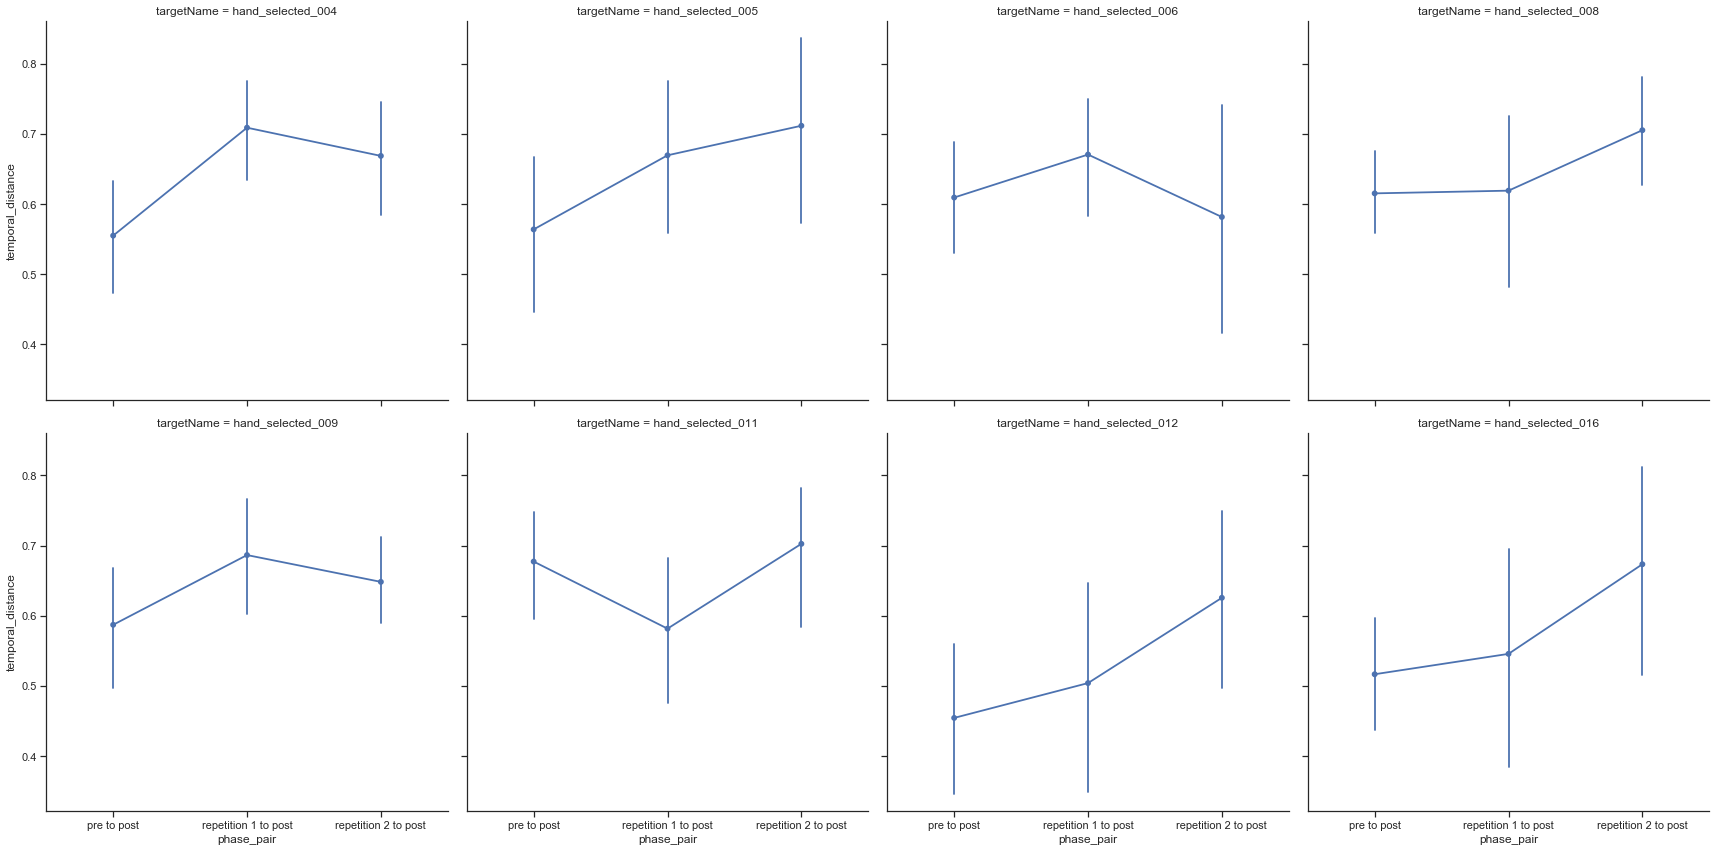

In [221]:
df_tmp = df_temporal[df_temporal.phase_pair.isin(['pre to post',
                                                    'repetition 1 to post',
                                                    'repetition 2 to post'])]


fig = plt.figure()
fig.set_size_inches(12, 16)
sns.set(style="ticks", rc={"lines.linewidth": 1})
g = sns.FacetGrid(df_tmp, col="targetName", col_wrap=4, height=6)
g.map(sns.pointplot, "phase_pair", "temporal_distance")

In [222]:
df_euclidean_distances

,targetName,gameID,level_2,phase_a,phase_b,actual_euclidean_distance,phase_pair
0,hand_selected_004,0145-8cab6010-6b88-4e57-b04d-b9e9b4b7c959,0,pre,post,5.088994,pre to post
1,hand_selected_004,0443-fd078367-c19d-495d-84d5-3519a281435d,0,pre,repetition 1,2.711420,pre to repetition 1
2,hand_selected_004,0443-fd078367-c19d-495d-84d5-3519a281435d,1,pre,repetition 2,2.490231,pre to repetition 2
3,hand_selected_004,0443-fd078367-c19d-495d-84d5-3519a281435d,2,pre,post,2.340887,pre to post
4,hand_selected_004,0443-fd078367-c19d-495d-84d5-3519a281435d,3,repetition 1,repetition 2,1.272144,repetition 1 to repetition 2
...,...,...,...,...,...,...,...
1367,hand_selected_016,9995-aa7dd1d6-ff3f-41e8-ade6-da416e7366c3,1,pre,repetition 2,0.816497,pre to repetition 2
1368,hand_selected_016,9995-aa7dd1d6-ff3f-41e8-ade6-da416e7366c3,2,pre,post,4.929865,pre to post
1369,hand_selected_016,9995-aa7dd1d6-ff3f-41e8-ade6-da416e7366c3,3,repetition 1,repetition 2,4.572609,repetition 1 to repetition 2
1370,hand_selected_016,9995-aa7dd1d6-ff3f-41e8-ade6-da416e7366c3,4,repetition 1,post,5.956067,repetition 1 to post


In [223]:
df_optimal_euclidean_distances

,targetName,gameID,level_2,phase_a,phase_b,optimal_euclidean_distance,phase_pair
0,hand_selected_004,0145-8cab6010-6b88-4e57-b04d-b9e9b4b7c959,0,pre,post,3.100925,pre to post
1,hand_selected_004,0443-fd078367-c19d-495d-84d5-3519a281435d,0,pre,repetition 1,0.844291,pre to repetition 1
2,hand_selected_004,0443-fd078367-c19d-495d-84d5-3519a281435d,1,pre,repetition 2,0.844291,pre to repetition 2
3,hand_selected_004,0443-fd078367-c19d-495d-84d5-3519a281435d,2,pre,post,0.936887,pre to post
4,hand_selected_004,0443-fd078367-c19d-495d-84d5-3519a281435d,3,repetition 1,repetition 2,0.000000,repetition 1 to repetition 2
...,...,...,...,...,...,...,...
1367,hand_selected_016,9995-aa7dd1d6-ff3f-41e8-ade6-da416e7366c3,1,pre,repetition 2,0.000000,pre to repetition 2
1368,hand_selected_016,9995-aa7dd1d6-ff3f-41e8-ade6-da416e7366c3,2,pre,post,1.746204,pre to post
1369,hand_selected_016,9995-aa7dd1d6-ff3f-41e8-ade6-da416e7366c3,3,repetition 1,repetition 2,2.793158,repetition 1 to repetition 2
1370,hand_selected_016,9995-aa7dd1d6-ff3f-41e8-ade6-da416e7366c3,4,repetition 1,post,1.320706,repetition 1 to post


In [224]:
df_temporal

,targetName,gameID,level_2,phase_a,phase_b,temporal_distance,phase_pair
0,hand_selected_004,0145-8cab6010-6b88-4e57-b04d-b9e9b4b7c959,0,pre,post,0.466667,pre to post
1,hand_selected_004,0443-fd078367-c19d-495d-84d5-3519a281435d,0,pre,repetition 1,0.418182,pre to repetition 1
2,hand_selected_004,0443-fd078367-c19d-495d-84d5-3519a281435d,1,pre,repetition 2,0.527273,pre to repetition 2
3,hand_selected_004,0443-fd078367-c19d-495d-84d5-3519a281435d,2,pre,post,0.757576,pre to post
4,hand_selected_004,0443-fd078367-c19d-495d-84d5-3519a281435d,3,repetition 1,repetition 2,0.890909,repetition 1 to repetition 2
...,...,...,...,...,...,...,...
1367,hand_selected_016,9995-aa7dd1d6-ff3f-41e8-ade6-da416e7366c3,1,pre,repetition 2,0.866667,pre to repetition 2
1368,hand_selected_016,9995-aa7dd1d6-ff3f-41e8-ade6-da416e7366c3,2,pre,post,-0.200000,pre to post
1369,hand_selected_016,9995-aa7dd1d6-ff3f-41e8-ade6-da416e7366c3,3,repetition 1,repetition 2,0.238095,repetition 1 to repetition 2
1370,hand_selected_016,9995-aa7dd1d6-ff3f-41e8-ade6-da416e7366c3,4,repetition 1,post,-0.222222,repetition 1 to post


In [225]:
df_euc = df_euclidean_distances.copy()
df_opt = df_optimal_euclidean_distances.copy()
df_time = df_temporal.copy()

In [115]:
# merge these three.
# add columns for accuracy, speed etc. in each rep

,targetName,gameID,level_2,rep_a,rep_b,actual_euclidean_distance,reps
0,hand_selected_004,0443-fd078367-c19d-495d-84d5-3519a281435d,0,0,1,2.711420,0 to 1
1,hand_selected_004,0443-fd078367-c19d-495d-84d5-3519a281435d,1,0,2,2.490231,0 to 2
2,hand_selected_004,0443-fd078367-c19d-495d-84d5-3519a281435d,2,0,3,2.340887,0 to 3
3,hand_selected_004,0443-fd078367-c19d-495d-84d5-3519a281435d,3,1,2,1.272144,1 to 2
4,hand_selected_004,0443-fd078367-c19d-495d-84d5-3519a281435d,4,1,3,2.222402,1 to 3
...,...,...,...,...,...,...,...
1171,hand_selected_016,9995-aa7dd1d6-ff3f-41e8-ade6-da416e7366c3,1,0,2,0.816497,0 to 2
1172,hand_selected_016,9995-aa7dd1d6-ff3f-41e8-ade6-da416e7366c3,2,0,3,4.929865,0 to 3
1173,hand_selected_016,9995-aa7dd1d6-ff3f-41e8-ade6-da416e7366c3,3,1,2,4.572609,1 to 2
1174,hand_selected_016,9995-aa7dd1d6-ff3f-41e8-ade6-da416e7366c3,4,1,3,5.956067,1 to 3


In [226]:
df_out = df_euc.merge(df_opt, how='left').merge(df_time, how='left')
df_out

,targetName,gameID,level_2,phase_a,phase_b,actual_euclidean_distance,phase_pair,optimal_euclidean_distance,temporal_distance
0,hand_selected_004,0145-8cab6010-6b88-4e57-b04d-b9e9b4b7c959,0,pre,post,5.088994,pre to post,3.100925,0.466667
1,hand_selected_004,0443-fd078367-c19d-495d-84d5-3519a281435d,0,pre,repetition 1,2.711420,pre to repetition 1,0.844291,0.418182
2,hand_selected_004,0443-fd078367-c19d-495d-84d5-3519a281435d,1,pre,repetition 2,2.490231,pre to repetition 2,0.844291,0.527273
3,hand_selected_004,0443-fd078367-c19d-495d-84d5-3519a281435d,2,pre,post,2.340887,pre to post,0.936887,0.757576
4,hand_selected_004,0443-fd078367-c19d-495d-84d5-3519a281435d,3,repetition 1,repetition 2,1.272144,repetition 1 to repetition 2,0.000000,0.890909
...,...,...,...,...,...,...,...,...,...
1367,hand_selected_016,9995-aa7dd1d6-ff3f-41e8-ade6-da416e7366c3,1,pre,repetition 2,0.816497,pre to repetition 2,0.000000,0.866667
1368,hand_selected_016,9995-aa7dd1d6-ff3f-41e8-ade6-da416e7366c3,2,pre,post,4.929865,pre to post,1.746204,-0.200000
1369,hand_selected_016,9995-aa7dd1d6-ff3f-41e8-ade6-da416e7366c3,3,repetition 1,repetition 2,4.572609,repetition 1 to repetition 2,2.793158,0.238095
1370,hand_selected_016,9995-aa7dd1d6-ff3f-41e8-ade6-da416e7366c3,4,repetition 1,post,5.956067,repetition 1 to post,1.320706,-0.222222


In [131]:
phases = ['pre', 'repetition 1', 'repetition 2', 'post']

In [228]:
df_out['phase_a_rawF1DiscreteScore'] = df_out.apply(lambda row: df[(df.targetName == row.targetName) &
                            (df.gameID == row.gameID) &
                            (df.phase_extended == row.phase_a)]['rawF1DiscreteScore'].values[0],
             axis = 1)

df_out['phase_b_rawF1DiscreteScore'] = df_out.apply(lambda row: df[(df.targetName == row.targetName) &
                            (df.gameID == row.gameID) &
                            (df.phase_extended == row.phase_b)]['rawF1DiscreteScore'].values[0],
             axis = 1)

df_out['condition'] = df_out.apply(lambda row: df[(df.targetName == row.targetName) &
                            (df.gameID == row.gameID)]['condition'].values[0], #haven't checked this line yet
             axis = 1)

In [229]:
df_out[df

,targetName,gameID,level_2,phase_a,phase_b,actual_euclidean_distance,phase_pair,optimal_euclidean_distance,temporal_distance,phase_a_rawF1DiscreteScore,phase_b_rawF1DiscreteScore,condition
0,hand_selected_004,0145-8cab6010-6b88-4e57-b04d-b9e9b4b7c959,0,pre,post,5.088994,pre to post,3.100925,0.466667,0.833333,0.500000,control
1,hand_selected_004,0443-fd078367-c19d-495d-84d5-3519a281435d,0,pre,repetition 1,2.711420,pre to repetition 1,0.844291,0.418182,0.945455,1.000000,repeated
2,hand_selected_004,0443-fd078367-c19d-495d-84d5-3519a281435d,1,pre,repetition 2,2.490231,pre to repetition 2,0.844291,0.527273,0.945455,1.000000,repeated
3,hand_selected_004,0443-fd078367-c19d-495d-84d5-3519a281435d,2,pre,post,2.340887,pre to post,0.936887,0.757576,0.945455,1.000000,repeated
4,hand_selected_004,0443-fd078367-c19d-495d-84d5-3519a281435d,3,repetition 1,repetition 2,1.272144,repetition 1 to repetition 2,0.000000,0.890909,1.000000,1.000000,repeated
...,...,...,...,...,...,...,...,...,...,...,...,...
1367,hand_selected_016,9995-aa7dd1d6-ff3f-41e8-ade6-da416e7366c3,1,pre,repetition 2,0.816497,pre to repetition 2,0.000000,0.866667,0.657143,0.694444,repeated
1368,hand_selected_016,9995-aa7dd1d6-ff3f-41e8-ade6-da416e7366c3,2,pre,post,4.929865,pre to post,1.746204,-0.200000,0.657143,0.755556,repeated
1369,hand_selected_016,9995-aa7dd1d6-ff3f-41e8-ade6-da416e7366c3,3,repetition 1,repetition 2,4.572609,repetition 1 to repetition 2,2.793158,0.238095,0.750000,0.694444,repeated
1370,hand_selected_016,9995-aa7dd1d6-ff3f-41e8-ade6-da416e7366c3,4,repetition 1,post,5.956067,repetition 1 to post,1.320706,-0.222222,0.750000,0.755556,repeated


In [155]:
out_path = os.path.join(csv_dir,'block_silhouette_{}_rep_distances.csv'.format(iteration_name))
df_out.to_csv(out_path)

In [16]:
targets = np.sort(df['targetName'].unique())

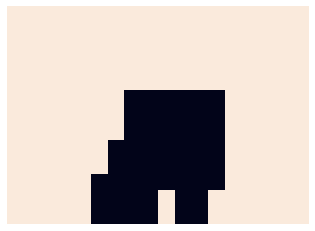

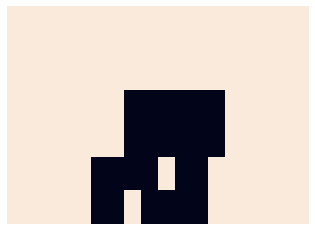

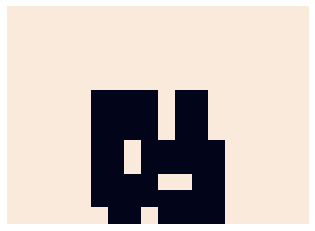

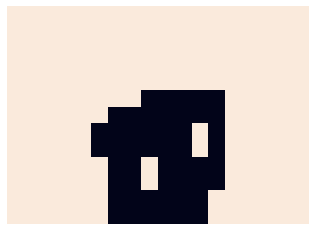

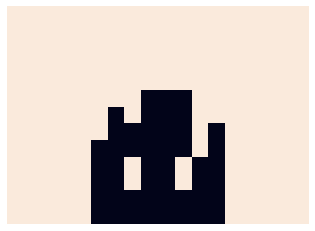

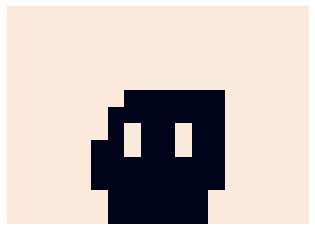

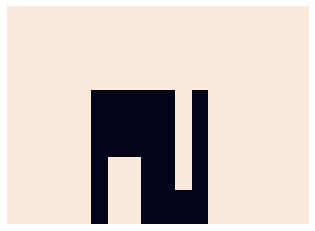

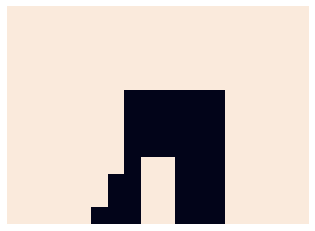

In [17]:
for target_name in targets:
    silhouette = 1*np.logical_not(target_maps[target_name])
    silhouette = np.rot90(silhouette)
    fig, ax = plt.subplots()
    ax.axis('off')
    ax.imshow(silhouette)

In [254]:
df_displacements[df_displacements.gameID==ppts[3]]

,targetName,gameID,level_2,rep_a,rep_b,displacement,reps
156,hand_selected_005,0622-493f8d2b-4aa3-4b1c-ad92-f6014b9fc709,0,0,1,0.000000,0 to 1
157,hand_selected_005,0622-493f8d2b-4aa3-4b1c-ad92-f6014b9fc709,1,0,2,0.055556,0 to 2
158,hand_selected_005,0622-493f8d2b-4aa3-4b1c-ad92-f6014b9fc709,2,0,3,0.111111,0 to 3
159,hand_selected_005,0622-493f8d2b-4aa3-4b1c-ad92-f6014b9fc709,3,1,2,0.098765,1 to 2
160,hand_selected_005,0622-493f8d2b-4aa3-4b1c-ad92-f6014b9fc709,4,1,3,0.100000,1 to 3
161,hand_selected_005,0622-493f8d2b-4aa3-4b1c-ad92-f6014b9fc709,5,2,3,0.049383,2 to 3
300,hand_selected_006,0622-493f8d2b-4aa3-4b1c-ad92-f6014b9fc709,0,0,1,0.160000,0 to 1
301,hand_selected_006,0622-493f8d2b-4aa3-4b1c-ad92-f6014b9fc709,1,0,2,0.326531,0 to 2
302,hand_selected_006,0622-493f8d2b-4aa3-4b1c-ad92-f6014b9fc709,2,0,3,0.285714,0 to 3
303,hand_selected_006,0622-493f8d2b-4aa3-4b1c-ad92-f6014b9fc709,3,1,2,0.320000,1 to 2


In [252]:
displacements[3,:,:,:]

array([[[       nan,        nan,        nan,        nan],
        [       nan,        nan,        nan,        nan],
        [       nan,        nan,        nan,        nan],
        [       nan,        nan,        nan,        nan]],

       [[       nan, 0.        , 0.05555556, 0.11111111],
        [0.        ,        nan, 0.09876543, 0.1       ],
        [0.11111111, 0.09876543,        nan, 0.04938272],
        [0.11111111, 0.1       , 0.04938272,        nan]],

       [[       nan, 0.16      , 0.32653061, 0.28571429],
        [0.16      ,        nan, 0.32      , 0.32      ],
        [0.32653061, 0.32      ,        nan, 0.0625    ],
        [0.28571429, 0.32      , 0.0625    ,        nan]],

       [[       nan,        nan,        nan,        nan],
        [       nan,        nan,        nan,        nan],
        [       nan,        nan,        nan,        nan],
        [       nan,        nan,        nan,        nan]],

       [[       nan, 0.24489796, 0.32653061, 0.28571429],
      